# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
# allows for a variable number of stacked grayscale images

In [126]:
import os
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid

In [177]:
# Model Hyperparameters

home_dir = os.environ["HOME"]
dataset_path = os.path.join(home_dir, "minerl/PyTorch-VAE/datasets/first_discrete/combined_gray")

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 200

# @TODO un-hardcode
x_dim  = 75 * 100 # H x W
hidden_dim = 500
latent_dim = 300

lr = 1e-4

epochs = 40

###    Step 1. Load (or download) Dataset

In [178]:
'''
from shutil import copyfile
import random

train_dir = os.path.join(dataset_path, "train")
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
    
val_dir = os.path.join(dataset_path, "val")
if not os.path.exists(val_dir):
    os.mkdir(val_dir)

# shuffles and splits the data into train and test
files = os.listdir(dataset_path)
    
for f in files:
    full = os.path.join(dataset_path, f)
    rand_sample = np.random.uniform(0,1,1)[0]
    # 15% in the validation set
    if rand_sample <= 0.85:
        # add to training set
        dst = os.path.join(train_dir, f)
    else:
        # add to validation
        dst = os.path.join(val_dir, f)
    copyfile(full, dst)
    
# ensure the above block works, then remove old
for f in files:
    full = os.path.join(dataset_path, f)
    os.remove(full)
'''

'\nfrom shutil import copyfile\nimport random\n\ntrain_dir = os.path.join(dataset_path, "train")\nif not os.path.exists(train_dir):\n    os.mkdir(train_dir)\n    \nval_dir = os.path.join(dataset_path, "val")\nif not os.path.exists(val_dir):\n    os.mkdir(val_dir)\n\n# shuffles and splits the data into train and test\nfiles = os.listdir(dataset_path)\n    \nfor f in files:\n    full = os.path.join(dataset_path, f)\n    rand_sample = np.random.uniform(0,1,1)[0]\n    # 15% in the validation set\n    if rand_sample <= 0.85:\n        # add to training set\n        dst = os.path.join(train_dir, f)\n    else:\n        # add to validation\n        dst = os.path.join(val_dir, f)\n    copyfile(full, dst)\n    \n# ensure the above block works, then remove old\nfor f in files:\n    full = os.path.join(dataset_path, f)\n    os.remove(full)\n'

In [179]:
# custom dataset for minecraft grayscale images
from PIL import Image
from torch.utils.data import Dataset
from natsort import natsorted

class MinecraftDataSet(Dataset):
    def __init__(self, main_dir, transform, train=True):
        if train:
            self.main_dir = os.path.join(main_dir, "train")
        else:
            self.main_dir = os.path.join(main_dir, "val")
        self.transform = transform
        all_imgs = os.listdir(self.main_dir)
        self.total_imgs = natsorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("L")
        # image = image.resize((28, 28), Image.ANTIALIAS)
        # image = Image.open(img_loc).convert("LA")
        # print(image.size)
        # print("image shape: ", np.array(image).shape)
        tensor_image = self.transform(image)
        return tensor_image

In [180]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader


mc_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((75, 100)),
])

kwargs = {'num_workers': 4, 'pin_memory': True} 

train_dataset = MinecraftDataSet(dataset_path, transform=mc_transform, train=True)
test_dataset  = MinecraftDataSet(dataset_path, transform=mc_transform, train=False)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [181]:
"""
    A simple implementation of Gaussian MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear(hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [182]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [183]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [184]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [185]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [186]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(-1, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  3979.62410170053
	Epoch 2 complete! 	Average Loss:  3831.364503643993
	Epoch 3 complete! 	Average Loss:  3820.2888957597174
	Epoch 4 complete! 	Average Loss:  3812.2562428224383
	Epoch 5 complete! 	Average Loss:  3802.7029085689046
	Epoch 6 complete! 	Average Loss:  3794.366893772085
	Epoch 7 complete! 	Average Loss:  3790.5596068904592
	Epoch 8 complete! 	Average Loss:  3787.4005841431094
	Epoch 9 complete! 	Average Loss:  3783.8695141342755
	Epoch 10 complete! 	Average Loss:  3780.238421488516
	Epoch 11 complete! 	Average Loss:  3777.642660114841
	Epoch 12 complete! 	Average Loss:  3775.9066624337456
	Epoch 13 complete! 	Average Loss:  3774.318206713781
	Epoch 14 complete! 	Average Loss:  3772.41695229682
	Epoch 15 complete! 	Average Loss:  3770.8865050795052
	Epoch 16 complete! 	Average Loss:  3769.815069015018
	Epoch 17 complete! 	Average Loss:  3768.918422040636
	Epoch 18 complete! 	Average Loss:  3768.2225049690815
	Epoch 1

### Step 5. Generate images from test dataset

In [187]:
import matplotlib.pyplot as plt

In [188]:
model.eval()

with torch.no_grad():
    for batch_idx, x in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

  0%|          | 0/51 [00:00<?, ?it/s]


In [189]:
def show_image(x, idx):
    x = x.view(-1, 75, 100)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy(), cmap='gray', vmin=0, vmax=1)

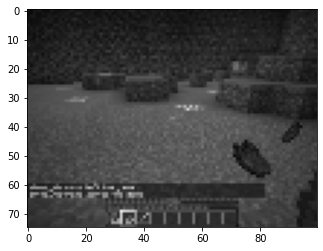

In [190]:
show_image(x, idx=0)

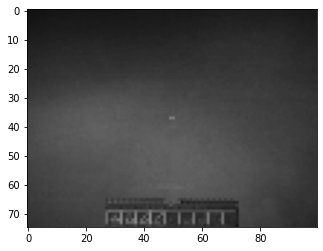

In [191]:
show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [192]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [193]:
save_image(generated_images.view(batch_size, 1, 75, 100), 'generated_sample.png')

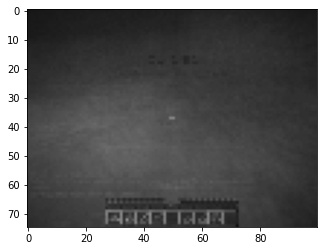

In [194]:
show_image(generated_images, idx=12)

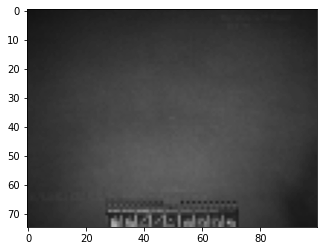

In [195]:
show_image(generated_images, idx=0)

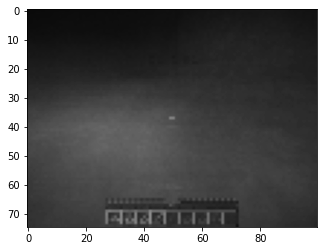

In [196]:
show_image(generated_images, idx=1)

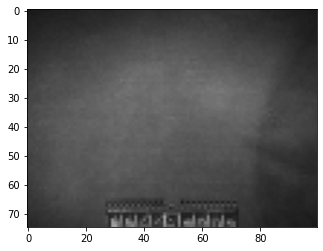

In [197]:
show_image(generated_images, idx=10)

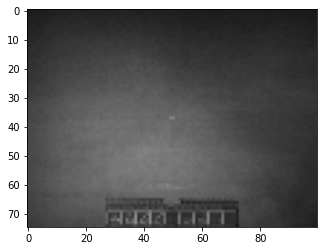

In [198]:
show_image(generated_images, idx=20)

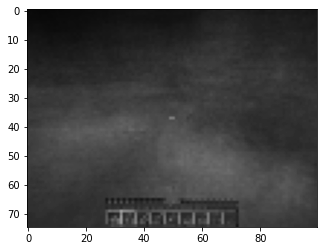

In [176]:
show_image(generated_images, idx=50)